The goal of this notebook is to calculate whether ancestry-associated guide-level dependency differences are restricted to guides with SNPs

In [2]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(janitor)

In [3]:
#First, load in the guide-level data
setwd("/home/jupyter/Ancestry/gwas")
replicate.map = read.table("internal-21q4_v9-achilles-replicate-map.csv", header = T, sep = ",")
guide.map = read.table("internal-21q4_v9-achilles-guide-map.csv", header = T, sep = ",")
logfc = read.table("internal-21q4_v9-achilles-logfold-change.csv", header = T, sep = ",", check.names = FALSE)

In [8]:
#Load in the ancestry information and create two vectors with the EAS and EUR lines
#Load in the ancestry data
setwd("/home/jupyter/Ancestry/rfmix")
ancestry.information = read.table("collapsed.ancestry.information.txt", sep = "\t", header = T)

#Get a vector of the EAS and EUR cell lines
eas.lines = ancestry.information %>% filter(EAS >= 0.8) %>% pull(sample)
eur.lines = ancestry.information %>% filter(EUR >= 0.8) %>% pull(sample)

In [9]:
#load in a list of the ancestry-associated genes
setwd('/home/jupyter/Ancestry/ccle_ancestry_analysis')
ancestry.associations = read.table("ancestry.associated.gene.associations.txt", sep = "\t", header = T)

#Get a list of all ancestry-associated genes
ancestry.associated.genes = ancestry.associations %>%
filter(FDR <= 0.05) %>%
pull(gene) %>%
unique()


head(ancestry.associations)
ancestry.associated.genes

,gene,pval,difference,ancestry,FDR
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,A1BG,0.07711508,2.518554e-02,AFR,0.8262291
2,A1CF,0.01553919,-4.901242e-02,AFR,0.7595784
3,A2M,0.82128228,7.297617e-05,AFR,0.9772673
4,A2ML1,0.66475156,-3.257814e-03,AFR,0.9476137
5,A3GALT2,0.89568474,-7.670531e-04,AFR,0.9866895
6,A4GALT,0.52781139,1.452687e-02,AFR,0.9160914


[1] "EEF2"      "NUP133"    "RESP18"    "ACAN"      "ADCY3"     "BTG1"     
 [7] "C22orf31"  "C2orf80"   "CBFA2T2"   "CCDC102B"  "CCDC74B"   "CCL3"     
[13] "CEP19"     "CHGB"      "CLSPN"     "COX6B1"    "DCN"       "DDX47"    
[19] "DND1"      "ECD"       "EGFR"      "FAM25A"    "FCGR3A"    "FRG2C"    
[25] "GLYCTK"    "GRB2"      "GTPBP3"    "HCN2"      "HINT3"     "HIST1H2AA"
[31] "HLA"       "HNF1B"     "INCENP"    "ITGA3"     "ITIH3"     "KIAA2013" 
[37] "KRTAP3"    "MATR3"     "MRTO4"     "MYH11"     "NAA40"     "NIT2"     
[43] "NKAIN4"    "NOP56"     "NPEPPS"    "NPHS1"     "PDXDC1"    "PEX11A"   
[49] "PTPN11"    "QRICH2"    "RAB21"     "RETNLB"    "RHD"       "RIMS2"    
[55] "RPL3"      "RPS5"      "RTP5"      "SART1"     "SCN5A"     "SLC10A5"  
[61] "SLC35B2"   "SLC38A7"   "SLC5A11"   "SNAP23"    "SPATA6L"   "SRP14"    
[67] "STX4"      "STXBP3"    "TPSD1"     "TRMT61B"   "TTC4"      "TUT1"     
[73] "TXNRD1"    "UGT2B17"   "VRK1"      "WSB2"      "ZNF675"    "APEX2"    
[79] "ATRX"      "C17orf64"  "COPG1"     "CSE1L"     "DEFB108B"  "ERI1"     
[85] "FAM86C1"   "IL1RN"     "KRT14"     "LPAR6"     "MDN1"      "NOMO2"    
[91] "PCBP4"     "PSPH"      "RPP30"     "SERINC2"   "XYLT2"     "ZFP62"

In [42]:
#Get a list of guides that we want to keep
guides.to.keep = guide.map %>%
mutate(gene = word(gene, 1)) %>%
filter(gene %in% ancestry.associated.genes) %>%
pull(sgrna)


#First, subset the logfc data so that it only includes the guides we are interested in.
#Then collapse and average by sample
guide.level.data = logfc %>%
rename("sgrna" = 1) %>%
filter(sgrna %in% all_of(guides.to.keep)) %>%
t() %>%
row_to_names(1, remove_rows_above = FALSE) %>%
data.frame() %>%
rownames_to_column("sample") %>%
mutate(sample = plyr::mapvalues(sample, from = replicate.map$replicate_ID, to = replicate.map$DepMap_ID, warn_missing = FALSE)) %>%
melt(id = "sample") %>%
mutate(value = as.numeric(value))%>%
group_by(sample, variable) %>%
summarise(mean(value)) %>%
dcast(sample ~ variable)

`summarise()` has grouped output by 'sample'. You can override using the `.groups` argument.

Using mean(value) as value column: use value.var to override.



,sample,AAACTTGTGCAAGCAGAAGG,AACAATGCCCGTTTGCTGCA,AACTACCTATGACAGTGCCG,AAGATCGTCGACATGTACAA,AAGCGGAGACTGTACAGAAA,AAGCTGCTCGATGAGAACAG,AAGCTGGCCTGGCTGCCGCG,AAGCTTATCGACACCATCAG,AAGTTCTTACCCCTTCCGGG,⋯,TTCTCCAGCTGATCAACCCG,TTGTGACTATAGAAGAAGCA,TTTATGAGCCAAGTTCTACC,TTTCATGTACAAACTCAGGT,TTTCATTCCAACTTACCTAA,TTTCATTCTCACTTACCTGG,TTTCCTTCCCAGCCACACCC,TTTGAAGTCATATTTGGCGA,TTTGGACTCGATACACCCCA,TTTGTTCTCAGCTTTCCGCT
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000004,0.57976141,0.41236856,0.5289671,0.02744621,0.47371507,-1.2896670,0.393045634,-0.06823323,0.025268563,⋯,-0.00514346,-0.14424420,-0.55860592,0.402147406,0.28523950,0.40864008,-0.0560691345,-1.2461330,-0.92225488,0.2039093
2,ACH-000005,0.42570015,0.26750105,-0.5662708,-0.32385555,-0.20137868,-0.5628353,0.021573843,0.03391238,0.131138126,⋯,0.25942509,-0.06196826,-0.07722676,-0.054986411,0.40127351,0.12960558,-0.0485438786,-0.7588070,-0.44282271,0.0546876
3,ACH-000007,0.40372715,0.13143873,-1.1990887,0.02905409,0.22391792,-1.2567061,-0.388499782,-0.07106481,0.043967128,⋯,-0.28406257,0.09020794,-0.25539100,0.358725919,0.62856407,0.16844942,0.1959574167,-1.0167328,-0.80462777,0.7894642
4,ACH-000009,0.72981144,0.03015656,-0.5288027,0.25006889,0.29236802,-1.3337604,0.314056886,0.50282109,0.031057677,⋯,-0.12666717,0.23788429,-0.71270460,0.479613725,-0.03538028,0.02793047,0.0782622890,-1.4291833,-1.24926530,0.1961114
5,ACH-000011,0.88516580,0.29459370,-0.6236395,-0.69850840,-0.52748660,-1.0491920,0.425287100,-0.10668190,-0.845764200,⋯,0.22133710,0.31846960,-1.39359600,-0.028550760,-1.25822600,-1.24624600,-0.4377080000,-2.4348810,-1.81927500,0.8648245
6,ACH-000012,0.42425863,0.06742984,-0.3164046,-0.57198461,0.38387767,-1.5182617,-0.257945923,-0.49052097,-0.321522685,⋯,0.31549627,-0.34488907,-0.46360112,0.013530873,-0.43599652,-0.30683907,-0.2431451183,-1.6026397,-2.23526925,0.3425860
7,ACH-000013,0.22483529,0.76130827,-0.7880709,-0.08569584,0.32599693,-1.3832034,0.603933459,0.01338726,0.003034372,⋯,-0.13304160,0.11358956,-0.01282599,0.180028217,0.23057384,0.12251791,-0.0908619310,-0.2052139,0.09640868,0.2844103
8,ACH-000014,0.37922335,0.01313396,-1.4139993,-0.49734627,0.13829385,-2.0535146,-0.167963719,-0.07234605,-0.602386023,⋯,-0.60828718,-0.01638450,-0.60893726,0.274334498,0.53416771,0.40645519,-0.3781789021,-1.5954061,-1.64098182,0.3584526
9,ACH-000015,0.02989737,0.23459058,-0.6659530,-0.34982274,-0.23604882,-1.4679002,-0.340086987,0.02097644,-0.113721544,⋯,0.26684246,0.37488594,-0.07384443,0.658664412,0.40995769,0.28257878,-0.0021388296,-0.9283534,-1.19355454,0.5008046


'data.frame':	976 obs. of  374 variables:
 $ sample              : chr  "ACH-000004" "ACH-000005" "ACH-000007" "ACH-000009" ...
 $ AAACTTGTGCAAGCAGAAGG: num  0.58 0.426 0.404 0.73 0.885 ...
 $ AACAATGCCCGTTTGCTGCA: num  0.4124 0.2675 0.1314 0.0302 0.2946 ...
 $ AACTACCTATGACAGTGCCG: num  0.529 -0.566 -1.199 -0.529 -0.624 ...
 $ AAGATCGTCGACATGTACAA: num  0.0274 -0.3239 0.0291 0.2501 -0.6985 ...
 $ AAGCGGAGACTGTACAGAAA: num  0.474 -0.201 0.224 0.292 -0.527 ...
 $ AAGCTGCTCGATGAGAACAG: num  -1.29 -0.563 -1.257 -1.334 -1.049 ...
 $ AAGCTGGCCTGGCTGCCGCG: num  0.393 0.0216 -0.3885 0.3141 0.4253 ...
 $ AAGCTTATCGACACCATCAG: num  -0.0682 0.0339 -0.0711 0.5028 -0.1067 ...
 $ AAGTTCTTACCCCTTCCGGG: num  0.0253 0.1311 0.044 0.0311 -0.8458 ...
 $ AATGCCTGGACACTGCACAG: num  -1.796 -0.603 -1.27 -1.753 -1.043 ...
 $ AATGTGGAGAAACTATCACC: num  -0.744 -0.188 -0.689 -0.465 0.262 ...
 $ AATTGAACTTCACCACCCAG: num  -0.47 -0.147 -0.715 -1.652 -2.283 ...
 $ AATTTGACCCAAAAGGAAGA: num  0.1621 0.1723 -0.1406 -0

[1] 976 374

In [45]:
###Now split the dataset into EAS and EUR cell lines and perform a t-test for each sgRNA

#Split the dataset
eur.scores = guide.level.data %>%
filter(sample %in% all_of(eur.lines))

eas.scores = guide.level.data %>%
filter(sample %in% all_of(eas.lines))

[1] 344 374

[1] 195 374

In [70]:
#First, calculate the difference in median across all of the guides
eur.median = eur.scores[2:ncol(eur.scores)] %>% apply(2, median)
eas.median = eas.scores[2:ncol(eas.scores)] %>% apply(2, median)
median.difference = eas.median - eur.median

#Now calculate a t-test between the two
t.test.vector = NULL
for(i in 2:ncol(eur.scores)){
    eas.vector = eas.scores[,i] #get a vector of sgRNA scores for the EAS lines
    eur.vector = eur.scores[,i] #get a vector of sgRNA scores for the EUR lines
    t.test.score = t.test(x = eas.vector, y = eur.vector, alternative = "two.sided")$p.value
    t.test.vector = c(t.test.vector, t.test.score)
}

In [69]:
#Now we need to figure out which guides have SNPs in them. Thankfully, we already wrote this code in "New_Which_Ancestry_Genes_Have_SNP_In_Guide"
#So let's just load it in the output from that notebook

setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
snp.positions = read.table("ancestry_guide_snp_positions.txt", sep = "\t", header = T)

#Get a list of guides that have at least one SNP
guides.with.snp = snp.positions %>%
apply(1, max)
guides.with.snp = guides.with.snp[guides.with.snp >= 1] %>% names()

[1] 72

In [83]:
#Now we can assemble the final data frame to make the plot
df.for.plot = cbind(median.difference, t.test.vector, colnames(guide.level.data)[2:ncol(guide.level.data)]) %>% 
data.frame() %>%
rename("sgrna" = V3) %>%
mutate("snp.code" = ifelse(sgrna %in% guides.with.snp, 1, 0)) %>%
mutate(median.difference = as.numeric(median.difference)) %>%
mutate(t.test.vector = as.numeric(t.test.vector)) %>%
mutate("fdr" = p.adjust(t.test.vector, method = "BH", n = length(t.test.vector)))
head(df.for.plot)

,median.difference,t.test.vector,sgrna,snp.code,fdr
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
AAACTTGTGCAAGCAGAAGG,0.052611368,4.721516e-03,AAACTTGTGCAAGCAGAAGG,0,1.505235e-02
AACAATGCCCGTTTGCTGCA,-0.009758467,6.091495e-01,AACAATGCCCGTTTGCTGCA,0,7.445043e-01
AACTACCTATGACAGTGCCG,-0.016366492,6.179038e-01,AACTACCTATGACAGTGCCG,0,7.445043e-01
AAGATCGTCGACATGTACAA,-0.048750614,9.483732e-02,AAGATCGTCGACATGTACAA,1,1.795651e-01
AAGCGGAGACTGTACAGAAA,0.124311703,8.126406e-07,AAGCGGAGACTGTACAGAAA,0,7.577874e-06
AAGCTGCTCGATGAGAACAG,0.017405415,4.157653e-01,AAGCTGCTCGATGAGAACAG,1,5.680603e-01


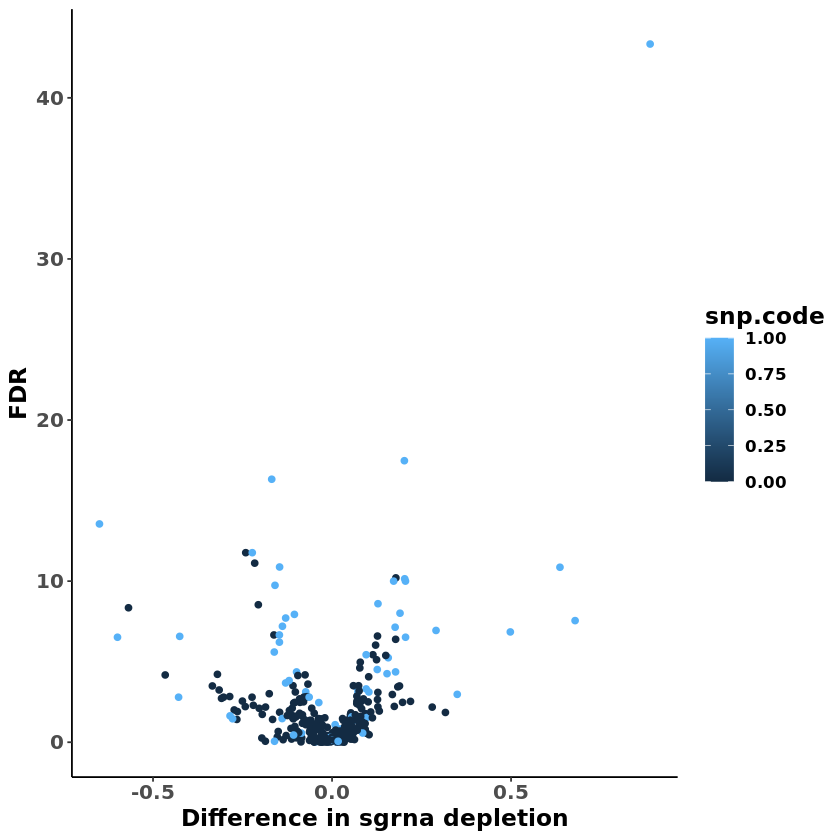

In [87]:
#Make the volcano plot
df.for.plot %>%
ggplot(aes(x = median.difference, y = -log10(fdr), color = snp.code)) +
geom_point(aes(x = median.difference, y = -log10(fdr), color = snp.code)) +
theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

ylab("FDR") +
xlab("Difference in sgrna depletion")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("single_guide_volcano.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp single_guide_volcano.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))